In [2]:
import os
import re

import numpy as np
from scipy import stats
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

In [3]:
from constants import CEN_YEARS
TORONTO_CENTER = (43.652, -79.383)  # Toronto city center coordinates (latitude, longitude)

## Analysis

In [3]:
records = []  # (year, imm, not_imm, pop, new_imm, vm, imm_2nd)

for cen_year in tqdm(CEN_YEARS):
    if (cen_year < 1961) or (cen_year == 1966) or (cen_year == 1976):
        continue

    # Remove this line if you want to process all years, not just 2021
    # if cen_year != 2021:
    #     continue

    # Load the data
    gdf_imm_stats = gpd.read_file(f"../data/immigration/{cen_year}/imm_stats_{cen_year}.gpkg")
    
    # Create non-immigrant count column
    gdf_imm_stats['num_not_imm_tot'] = gdf_imm_stats['num_pop_tot'] - gdf_imm_stats['num_imm_tot']
    
    # Create normalized weights
    gdf_imm_stats['pop_norm'] = gdf_imm_stats['num_pop_tot'] / gdf_imm_stats['num_pop_tot'].sum()
    gdf_imm_stats['imm_norm'] = gdf_imm_stats['num_imm_tot'] / gdf_imm_stats['num_imm_tot'].sum()
    gdf_imm_stats['not_imm_norm'] = gdf_imm_stats['num_not_imm_tot'] / gdf_imm_stats['num_not_imm_tot'].sum()
    if cen_year >= 1981:
        gdf_imm_stats['imm_new_norm'] = gdf_imm_stats['num_imm_new'] / gdf_imm_stats['num_imm_new'].sum()
    if cen_year >= 1996:
        gdf_imm_stats['vm_norm'] = gdf_imm_stats['num_vm_tot'] / gdf_imm_stats['num_vm_tot'].sum()
    if cen_year >= 2001:
        gdf_imm_stats['imm_2nd_norm'] = gdf_imm_stats['num_imm_2nd_tot'] / gdf_imm_stats['num_imm_2nd_tot'].sum()

    # Create centroids - ensure CRS is appropriate for distance calculations
    gdf_imm_stats = gdf_imm_stats.to_crs('EPSG:3857')  # Convert to projected CRS for accurate distance calculations
    gdf_imm_stats['centroid'] = gdf_imm_stats.geometry.centroid
    
    # Create Point for Toronto center in the same CRS
    toronto_center = gpd.points_from_xy([TORONTO_CENTER[1]], [TORONTO_CENTER[0]], crs='EPSG:4326').to_crs('EPSG:3857')[0]
    
    # Calculate distances from each centroid to Toronto center (in meters)
    gdf_imm_stats['distance'] = gdf_imm_stats['centroid'].distance(toronto_center)
    
    # Calculate weighted mean distances
    weighted_imm_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['imm_norm']).sum()
    weighted_not_imm_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['not_imm_norm']).sum()
    weighted_pop_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['pop_norm']).sum()
    
    weighted_imm_new_dist = np.nan
    weighted_vm_dist = np.nan
    weighted_imm_2nd_dist = np.nan
    if cen_year >= 1981:
        weighted_imm_new_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['imm_new_norm']).sum()
    if cen_year >= 1996:
        weighted_vm_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['vm_norm']).sum()
    if cen_year >= 2001:
        weighted_imm_2nd_dist = (gdf_imm_stats['distance'] * gdf_imm_stats['imm_2nd_norm']).sum()

    # Convert distances to kilometers
    records.append(
        (
            cen_year,
            weighted_imm_dist / 1000,
            weighted_not_imm_dist / 1000,
            weighted_pop_dist / 1000,
            weighted_imm_new_dist / 1000,
            weighted_vm_dist / 1000,
            weighted_imm_2nd_dist / 1000,
        )
    )

# Convert to pandas DataFrame
df_dists = pd.DataFrame.from_records(records, columns=['year', 'imm', 'not_imm', 'pop', 'imm_new', 'vm', 'imm_2nd'])
df_dists.to_csv('../data/immigration/stats/pop_dists.csv', index=False)
df_dists.to_csv('../static/data/immigration_analysis/pop_dists.csv', index=False)

100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


In [7]:
for cen_year in tqdm(CEN_YEARS):
    if cen_year not in [1961, 1981, 2001, 2021]:
        continue

    gdf_imm_stats = gpd.read_file(f"../data/immigration/{cen_year}/imm_stats_{cen_year}.gpkg")
    
    # Create non-immigrant count column
    gdf_imm_stats['num_not_imm_tot'] = gdf_imm_stats['num_pop_tot'] - gdf_imm_stats['num_imm_tot']

    # Convert to projected CRS before centroid calculation
    gdf_imm_stats = gdf_imm_stats.to_crs('EPSG:3857')
    
    # Calculate centroids on the projected geometry
    gdf_imm_stats['centroid'] = gdf_imm_stats['geometry'].centroid
    
    # Create Toronto center point (already in EPSG:3857)
    toronto_center_geom = gpd.points_from_xy(
        [TORONTO_CENTER[1]], 
        [TORONTO_CENTER[0]], 
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')[0]
    
    # Calculate distances (using projected coordinates)
    gdf_imm_stats['distance'] = gdf_imm_stats['centroid'].distance(toronto_center_geom) / 1000
    gdf_imm_stats = gdf_imm_stats[gdf_imm_stats['distance'] <= 50]
    gdf_imm_stats = gdf_imm_stats.dropna(subset=['geometry'])
    
    # Create distance bins - ensure we have complete coverage up to 50km
    max_distance = min(int(gdf_imm_stats['distance'].max()) + 1, 50)
    bin_size = 1

    bins = list(range(0, max_distance + 1, bin_size))
    labels = list(range(bin_size, max_distance + 1, bin_size))
    
    # Use pandas' cut with explicit bins and labels
    gdf_imm_stats['dist_bin'] = pd.cut(
        gdf_imm_stats['distance'],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )
    
    # Group with observed=True to handle categorical bins
    grouped = gdf_imm_stats.groupby('dist_bin', observed=True).agg({
        'num_pop_tot': 'sum',
        'num_not_imm_tot': 'sum',
        'num_imm_tot': 'sum',
        'num_imm_new': 'sum',
        'num_vm_tot': 'sum',
        'num_imm_2nd_tot': 'sum'
    }).reset_index()
    
    # Ensure complete distance coverage
    grouped = grouped.rename(columns={'dist_bin': 'dist_km'})
    all_bins = pd.DataFrame({'dist_km': labels})
    grouped = all_bins.merge(grouped, on='dist_km', how='left').fillna(0)
    grouped['dist_km'] = grouped['dist_km'].astype(int)
    
    # Save results
    grouped.to_csv(f"../data/immigration/stats/imm_dist_{cen_year}.csv", index=False)
    grouped.to_csv(f'../static/data/immigration_analysis/imm_dist_{cen_year}.csv', index=False)

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_935827/2058346364.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped = all_bins.merge(grouped, on='dist_km', how='left').fillna(0)
 20%|██        | 3/15 [00:00<00:00, 28.31it/s]/tmp/ipykernel_935827/2058346364.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped = all_bins.merge(grouped, on='dist_km', how='left').fillna(0)
 47%|████▋     | 7/15 [00:00<00:00, 32.38it/s]/tmp/ipykernel_935827/2058346364.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

## Visualization

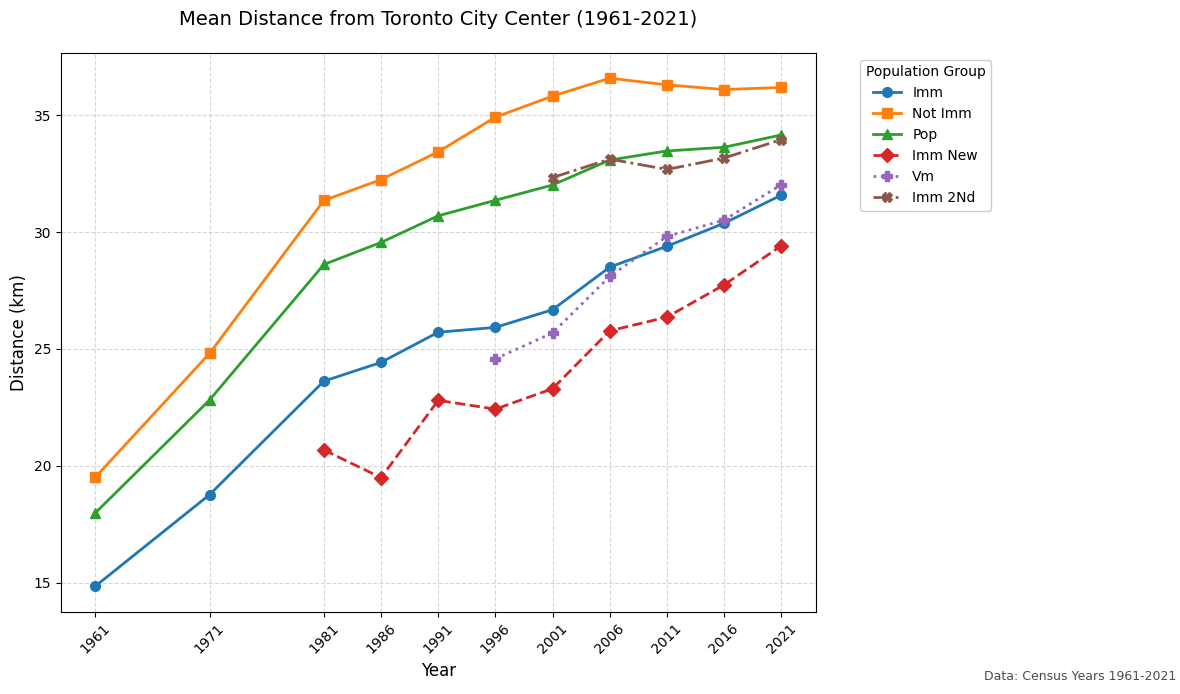

In [5]:
df_dists = pd.read_csv('../data/immigration/stats/pop_dists.csv')

# Color palette designed for clarity with 6 lines
COLORS = {
    'imm': '#1f77b4',        # Blue
    'not_imm': '#ff7f0e',    # Orange
    'pop': '#2ca02c',        # Green
    'imm_new': '#d62728',    # Red
    'vm': '#9467bd',         # Purple
    'imm_2nd': '#8c564b'     # Brown
}

# Marker styles for each line
MARKERS = {
    'imm': 'o',
    'not_imm': 's',
    'pop': '^',
    'imm_new': 'D',
    'vm': 'P',
    'imm_2nd': 'X'
}

# Line styles to further differentiate
LINE_STYLES = {
    'imm': '-',
    'not_imm': '-',
    'pop': '-',
    'imm_new': '--',
    'vm': ':',
    'imm_2nd': '-.'
}

plt.figure(figsize=(12, 7))

# Plot each line with distinct styling
for col in ['imm', 'not_imm', 'pop', 'imm_new', 'vm', 'imm_2nd']:
    if col in df_dists.columns and not df_dists[col].isnull().all():
        plt.plot(df_dists['year'], df_dists[col],
                marker=MARKERS[col],
                linestyle=LINE_STYLES[col],
                color=COLORS[col],
                label=col.replace('_', ' ').title(),
                markersize=7,
                linewidth=2)

# Chart formatting
plt.title('Mean Distance from Toronto City Center (1961-2021)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance (km)', fontsize=12)
plt.xticks(df_dists['year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Custom legend placement and styling
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    framealpha=1,
    title='Population Group'
)

# Adjust layout and add padding
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend

# Optional: Add annotation about data source
plt.annotate('Data: Census Years 1961-2021',
            xy=(0.98, 0.02),
            xycoords='figure fraction',
            ha='right',
            fontsize=9,
            alpha=0.7)

plt.savefig('../data/immigration/graphs/toronto_distance_trends.png', dpi=300, bbox_inches='tight')

In [8]:
# Configure bins and plotting
max_distance = 50  # km
bin_width = 1      # km
bins = np.arange(0, max_distance + bin_width, bin_width)

# Years and variables to plot
years = [1961, 1981, 2001, 2021]
variables = [
    'num_pop_tot',
    'num_imm_tot',
    'num_not_imm_tot',
    'num_imm_new',
    'num_vm_tot',
    'num_imm_2nd_tot'
]

# Title mapping
title_map = {
    'num_pop_tot': 'Total Population',
    'num_imm_tot': 'Immigrants',
    'num_not_imm_tot': 'Non-immigrants',
    'num_imm_new': 'New Immigrants',
    'num_vm_tot': 'Visible Minorities',
    'num_imm_2nd_tot': '2nd Gen Immigrants'
}

for cen_year in tqdm(years):
    # Load and prepare data
    gdf = gpd.read_file(f"../data/immigration/{cen_year}/imm_stats_{cen_year}.gpkg")
    
    # Calculate non-immigrants
    gdf['num_not_imm_tot'] = gdf['num_pop_tot'] - gdf['num_imm_tot']
    
    # Calculate distances (convert to km)
    gdf = gdf.to_crs('EPSG:3857')
    toronto_center = gpd.points_from_xy([-79.383], [43.652], crs='EPSG:4326').to_crs('EPSG:3857')[0]
    gdf['distance'] = gdf.geometry.centroid.distance(toronto_center) / 1000
    
    for var in variables:
        # Skip variables that don't exist or shouldn't exist yet
        if var not in gdf.columns:
            continue
        if (var == 'num_vm_tot' and cen_year < 1996) or \
           (var == 'num_imm_2nd_tot' and cen_year < 2001) or \
           (var == 'num_imm_new' and cen_year < 1981):
            continue
            
        # Filter out NA values
        valid_data = gdf[~gdf[var].isna()]
        if len(valid_data) == 0:
            continue
            
        # Create figure
        plt.figure(figsize=(12, 7))
        
        # Plot histogram with proper weights
        counts, edges, _ = plt.hist(
            valid_data['distance'],
            weights=valid_data[var],
            bins=bins,
            edgecolor='white',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Formatting
        plt.title(f'{title_map.get(var, var)} Distribution by Distance from Toronto Center ({cen_year})', pad=20)
        plt.xlabel('Distance from City Center (km)')
        plt.ylabel('Population Count')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        
        # Set y-axis limit with some headroom
        if len(counts) > 0:
            plt.ylim(0, counts.max() * 1.15)
        
        # Create directory if needed
        os.makedirs(f'../data/immigration/graphs/{var}', exist_ok=True)
        
        # Save figure
        plt.savefig(
            f'../data/immigration/graphs/{var}/{cen_year}.png',
            dpi=300,
            bbox_inches='tight'
        )
        plt.close()

100%|██████████| 4/4 [00:07<00:00,  1.87s/it]
